In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn import tree
import graphviz
from os import system
import sklearn.metrics as mt
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report, mean_squared_error, r2_score
import pydotplus
from sklearn.model_selection import cross_val_score, cross_validate,train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import AdaBoostClassifier

# 데이터 불러오기 및 전처리 과정(모든 모델에 동일부분임)

In [2]:
data = pd.read_csv('data_file_csv.csv', encoding='cp949')

In [3]:
#딕셔너리에 키 값을 대입해 벨류값을 얻어오는 함수
def get_value(k,dic):
    for key, value in dic.items():
         if k == key:
            return value
        
#string, float등 의사결정나무에서는 사용하기 힘든 변수를 사용할 수 있게끔 만들어주는 함수
def get_index(name):
    temp_list = data[name].tolist()
    temp_set = set(temp_list)
    temp_list2 = list(temp_set)
    dic= {string:i for i,string in enumerate(temp_list2)}
    
    for i in range(len(temp_list)):
        temp = data.loc[i,name]
        temp_value = get_value(temp,dic)
        data.loc[i,name] = temp_value
        
#여기서부터 srartpos1에 있는 string 값들을 전부 숫자로 바꿔주는 작업
get_index('startpos1')
    
#여기서부터 startpos2에 있는 string 값들을 전부 숫자로 바꿔주는 작업
get_index('startpos2')
    
#여기서부터 endpos2에 있는 string 값들을 전부 숫자로 바꿔주는 작업
get_index('endpos2')
data.drop(columns=["Unnamed: 0"],inplace=True)
data['startpos1'] = pd.to_numeric(data['startpos1'])
data['startpos2'] = pd.to_numeric(data['startpos2'])
# list로 만들기
list_whycall=data['whycall'].to_list()
list_gotoschool=data['gotoschool'].to_list()
list_gotocharge=data['gotocharge'].to_list()
# end_destination에 연산결과 추가하기
data['end_destination'] = 0
for i in range(len(list_whycall)):
    if (list_whycall[i] *100+ 
                           list_gotoschool[i]*10+
                           list_gotocharge[i] == 100) :
        data.iloc[i, 21] = 3
    elif (list_whycall[i] *100+ 
                           list_gotoschool[i]*10+
                           list_gotocharge[i] == 10) :
        data.iloc[i, 21] = 2
    elif (list_whycall[i] *100+ 
                           list_gotoschool[i]*10+
                           list_gotocharge[i] == 10) :
        data.iloc[i, 21] = 1
    else :
        data.iloc[i, 21] = 0
#변수 endlat과 endlon을 합치는 작업
te_list = data['startlat'].tolist()
for i in range (len(te_list)):
    data.loc[i,'startplus'] = ['1']

for i in range (len(te_list)):
    a = data.loc[i,'startlat']
    b = data.loc[i,'startlon']
    
    a = a * 10
    b = b * 10
    a = a % 100
    b = b % 100
    a = int(a)
    b = int(b)
    new = a*100 + b
    data.loc[i,'startplus'] = [new]
data.head()

,no,cartype,receipttime,settime,ridetime,startpos1,startpos2,endpos1,endpos2,receipt,...,startlat,startlon,endlat,endlon,whycall,gotoschool,gotocharge,endplus,end_destination,startplus
0,8075,중형 승합,2022-05-07 오전 12:08:21,2022-05-07 오전 12:15:19,2022-05-07 오전 12:30:26,7,235,동작구,155,2022/05/07 0:08,...,37.53,126.90,37.49,126.90,0,0,0,7469,0,7569
1,8231,중형승합,2022-05-07 오전 12:08:51,2022-05-07 오전 12:17:25,2022-05-07 오전 12:46:23,13,255,관악구,141,2022/05/07 0:08,...,37.50,126.88,37.47,126.97,0,0,0,7469,0,7568
2,8279,중형 승합,2022-05-07 오전 12:09:00,2022-05-07 오전 12:26:57,2022-05-07 오전 12:54:43,8,172,노원구,178,2022/05/07 0:09,...,37.67,127.08,37.64,127.07,0,0,0,7670,0,7670
3,1560,중형 승합,2022-05-07 오전 12:13:00,2022-05-07 오전 12:14:01,2022-05-07 오전 12:14:25,6,70,강동구,235,2022/05/07 0:13,...,37.59,127.08,37.54,127.13,0,0,0,7571,0,7570
4,7913,중형승합,2022-05-07 오전 12:18:00,2022-05-07 오전 1:15:54,2022-05-07 오전 1:33:16,6,307,동대문구,209,2022/05/07 0:18,...,37.61,127.09,37.57,127.06,0,0,0,7570,0,7670


In [4]:
X = data.loc[:,[
    'hour','receipt-ride','startpos1',
    'startpos2','end_destination', 'startplus']]
y = data['endplus']
y.unique()

array([7469, 7670, 7571, 7570, 7569, 7568, 7671, 7470, 7669, 7471, 7468],
      dtype=int64)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Adaboost

In [6]:
#base model : 의사결정나무(랜덤 스테이트 10 설정)
base_model = DecisionTreeRegressor(random_state=10)

In [7]:
#ada model 생성(파라미터는 아래와 같다.)
ada_model = AdaBoostRegressor(
        base_estimator=base_model,
        n_estimators=10,
        learning_rate=0.1).fit(X_train,y_train)

In [8]:
#주어진 데이터와 레이블의 
#train, test 각각의 평균 정확도를 반환
print('train set_ada_model : ',ada_model.score(X_train,y_train))
print('test set_ada_model : ',ada_model.score(X_test,y_test))

train set_ada_model :  0.9609165799403795
test set_ada_model :  0.4293244091785995


In [9]:
#train 데이터의 각종 회귀지표 분석
ytr_pred=ada_model.predict(X_train)
ada_mse = mean_squared_error(ytr_pred,y_train)
ada_r2 = r2_score(ytr_pred,y_train)
print("MSE: %.2f" % ada_mse)
print('MAE: ', mean_absolute_error(y_train, ytr_pred))
print("RMSE: %.2f" % np.sqrt(ada_mse))
print("R2: %.2f" % ada_r2)

MSE: 142.64
MAE:  1.948311363171878
RMSE: 11.94
R2: 0.96


In [10]:
#test 데이터의 각종 회귀지표 분석
yte_pred=ada_model.predict(X_test)
ada_mse = mean_squared_error(y_test, yte_pred)
ada_r2 = r2_score(y_test, yte_pred)
print("MSE: %.2f" % ada_mse)
print('MAE: ', mean_absolute_error(y_test, yte_pred))
print("RMSE: %.2f" % np.sqrt(ada_mse))
print("R2: %.2f" % ada_r2)

MSE: 2166.68
MAE:  20.146233974358974
RMSE: 46.55
R2: 0.43


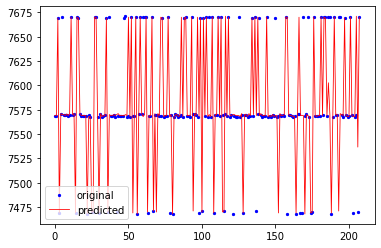

In [11]:
#y predict 시각화
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, yte_pred, lw=0.8, color="red", label="predicted")
plt.rcParams["figure.figsize"] = (12,6)
plt.legend()
plt.show()

# Gradient boost

In [12]:
#gb model 생성(파라미터는 아래와 같다.)
gb_model = GradientBoostingRegressor(
        n_estimators=1000,
        max_depth=8,
        learning_rate=0.1,
        min_samples_split=3)

In [13]:
#주어진 데이터와 레이블의 
#train, test 각각의 평균 정확도를 반환
gb_model.fit(X_train,y_train)
print('train set_ada_model : ',gb_model.score(X_train,y_train))
print('test set_ada_model : ',gb_model.score(X_test,y_test))

train set_ada_model :  0.9771327811274912
test set_ada_model :  0.5157153176764138


In [14]:
#train 데이터의 각종 회귀지표 분석
ytr_pred = gb_model.predict(X_train)
gb_mse = mean_squared_error(y_train,ytr_pred)
gb_r2 = r2_score(y_train, ytr_pred)

print("MSE: %.2f" % gb_mse)
print('MAE: ', mean_absolute_error(y_train, ytr_pred))
print("RMSE: %.2f" % np.sqrt(gb_mse))
print("R2: %.2f" % ada_r2)

MSE: 83.46
MAE:  1.3838924214393034
RMSE: 9.14
R2: 0.43


In [15]:
#test 데이터의 각종 회귀지표 분석
yte_pred = gb_model.predict(X_test)
gb_mse = mean_squared_error(y_test,yte_pred)
gb_r2 = r2_score(y_test, yte_pred)

print("MSE: %.2f" % gb_mse)
print('MAE: ', mean_absolute_error(y_test, yte_pred))
print("RMSE: %.2f" % np.sqrt(gb_mse))
print("R2: %.2f" % ada_r2)

MSE: 1838.68
MAE:  25.52824931955397
RMSE: 42.88
R2: 0.43


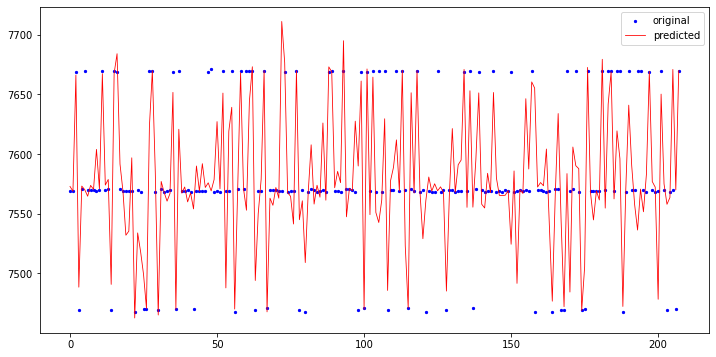

In [16]:
#y predict 시각화
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
#plt.plot(x_ax, bg_ytr_pred, lw=0.8, color="red", label="predicted")
plt.plot(x_ax, yte_pred, lw=0.8, color="red", label="predicted")
plt.rcParams["figure.figsize"] = (12,6)
plt.legend()
plt.show()